In [3]:
import pandas as pd
import numpy as np
import re
data = pd.read_csv('properatti.csv')
title = data['title']
description = data['description']

In [4]:
#buscamos mediante un patron y el uso de expresiones regulares los precios en USD que estan en la columna de title
patron = '^U\$D \d*.\d* '
title_regex = re.compile(patron)
resultado = title.apply(lambda x:  x if x is np.NaN else title_regex.search(x))
#buscamos mediante un patron y el uso de expresiones regulares los precios en USD que estan en la columna de description
patron_d = 'U\$S \d*.\d*'
description_regex = re.compile(patron_d)
resultado_d = description.apply(lambda x:  x if x is np.NaN else description_regex.search(x))
#buscamos mediante un patron y el uso de expresiones regulares los m2 que estan en la columna de title
patron_m = '(?:\d+ (?:m2|M2)|\d+(?:m2|M2))'
title_regex_m = re.compile(patron_m)
resultado_m = title.apply(lambda x:  x if x is np.NaN else title_regex_m.search(x))

In [5]:
# las coincidencias con el patron se volcaron a nueva columna Titleclean
mask_notnull = resultado.notnull()
data.loc[mask_notnull, "TitleClean"] = resultado[mask_notnull].apply(lambda x: x.group(0))
dolar= data.loc[mask_notnull, ["TitleClean"]]
# las coincidencias con el patron se volcaron a nueva columna Descriptionclean
mask_notnull_d = resultado_d.notnull()
data.loc[mask_notnull_d, "DescriptionClean"] = resultado_d[mask_notnull_d].apply(lambda x: x.group(0))
dolar_d= data.loc[mask_notnull_d, ["DescriptionClean"]]
# las coincidencias con el patron se volcaron a nueva columna Title_m2
mask_notnull_m = resultado_m.notnull()
data.loc[mask_notnull_m, "Title_m2"] = resultado_m[mask_notnull_m].apply(lambda x: x.group(0))
dolar_m= data.loc[mask_notnull_m, ["Title_m2"]]

In [6]:
# Cambiamos el type a string
title_clean = data['TitleClean']
title_clean2 = title_clean.apply(str)
description_clean = data['DescriptionClean']
description_clean2 = description_clean.apply(str)
title_clean_m = data['Title_m2']
title_clean_m2 = title_clean_m.apply(str)

In [7]:
# mediante el uso de un nuevo patron quitamos el signo U$D para quedarnos solo con el precio (sin la moneda)
patron_usd = '\d+.\d+'
title_clean2_regex = re.compile(patron_usd)
resultado2 = title_clean2.apply(lambda x:  x if x is np.NaN else title_clean2_regex.search(x))
# mediante el uso de un nuevo patron quitamos el signo U$S para quedarnos solo con el precio (sin la moneda)
patron_usd_d = '\d+.\d+'
description_clean2_regex = re.compile(patron_usd_d)
resultado2_d = description_clean2.apply(lambda x:  x if x is np.NaN else description_clean2_regex.search(x))
# mediante el uso de un nuevo patron quitamos el signo m2 para quedarnos solo con la superficie
patron_m2 = '^\d+'
title_clean_m2_regex = re.compile(patron_m2)
resultado2_m = title_clean_m2.apply(lambda x:  x if x is np.NaN else title_clean_m2_regex.search(x))

In [8]:
# lo volcamos a una nueva columna SinUSD
mask2_notnull = resultado2.notnull()
data.loc[mask2_notnull, "SinUSD"] = resultado2[mask2_notnull].apply(lambda x: x.group(0))
dolar2= data.loc[mask2_notnull, ["SinUSD"]]
# lo volcamos a una nueva columna SinUSS
mask2_notnull_d = resultado2_d.notnull()
data.loc[mask2_notnull_d, "SinUSS"] = resultado2_d[mask2_notnull_d].apply(lambda x: x.group(0))
dolar2_d= data.loc[mask2_notnull_d, ["SinUSS"]]
# lo volcamos a una nueva columna Sin_m2
mask2_notnull_m = resultado2_m.notnull()
data.loc[mask2_notnull_m, "Sin_m2"] = resultado2_m[mask2_notnull_m].apply(lambda x: x.group(0))
dolar2_m= data.loc[mask2_notnull_m, ["Sin_m2"]]

In [9]:
#completamos los campos vacios de precios en usd por lo nuevos ,sacados de title, reflejados en SinUSD
data.price_aprox_usd.fillna(data.SinUSD, inplace=True)
#completamos los campos vacios de precios en usd por lo nuevos ,sacados de description, reflejados en SinUSS
data.price_aprox_usd.fillna(data.SinUSS, inplace=True)
#completamos los campos vacios de metros en m2 por lo nuevos ,sacados de title, reflejados en Sin_m2
data.surface_total_in_m2.fillna(data.Sin_m2, inplace=True)

In [10]:
#creamos un sub data solo con los valores de Capital Federal
caba = data.state_name == "Capital Federal"
data_caba = data [caba]

In [12]:
# Dropeamos las filas que tienen el precio nulo
data_caba.dropna(subset=['price_aprox_usd'], inplace=True)

In [13]:
# no quedan propiedades sin precio, quedan 5405 sin m2
print(data_caba.price_aprox_usd.isnull().sum())
print(data_caba.surface_total_in_m2.isnull().sum())

0
5405


In [14]:
#Agrupamos por barrio
dataset_groupby_barrio = data_caba.groupby('place_name')

In [15]:
#Completamos los valores nulos de price_usd_per_m2 con el promedio segun su barrio, usando transform y lambda.
price_m2_usd_filled = dataset_groupby_barrio['price_usd_per_m2'].transform(lambda grp: grp.fillna(grp.mean()))

In [16]:
#Completamos los valores nulos de price_per_m2 con el promedio segun su barrio, usando transform y lambda.
price_m2_filled = dataset_groupby_barrio['price_per_m2'].transform(lambda grp: grp.fillna(grp.mean()))

In [18]:
#Agregamos la columna de m2_usd_filled al dataset
data_caba.loc[:, ['price_usd_m2_filled']] = price_m2_usd_filled
price_usd_fill = data_caba['price_usd_m2_filled']

In [19]:
#Agregamos la columna de m2_usd_filled al dataset
data_caba.loc[:, ['price_m2_filled']] = price_m2_filled
price_m2_fill = data_caba['price_m2_filled']

In [20]:
pd.options.display.max_columns = None
data_caba

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,TitleClean,DescriptionClean,Title_m2,SinUSD,SinUSS,Sin_m2,price_usd_m2_filled,price_m2_filled
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.00,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,NaN,NaN,NaN,NaN,NaN,NaN,1127.272727,1550.000000
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.00,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,NaN,NaN,NaN,NaN,NaN,NaN,1309.090909,1309.090909
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,95000.0,USD,1676227.50,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,NaN,NaN,NaN,NaN,NaN,NaN,1803.908335,2278.839694
7,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,138000.0,USD,2434941.00,138000.0,45.0,40.0,3066.666667,3450.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bot_venta_depart...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,https://thumbs4.properati.com/1/IHxARynlr8sPEW...,NaN,NaN,NaN,NaN,NaN,NaN,3066.666667,3450.000000
8,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,195000.0,USD,3440677.50,195000.0,65.0,60.0,3000.000000,3250.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bou_venta_depart...,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...,NaN,NaN,NaN,NaN,NaN,NaN,3000.000000,3250.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121160,121160,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.563685346,-58.4426825896",-34.563685,-58.442683,410000.0,USD,7234245.00,410000.0,157.0,NaN,2611.464968,NaN,NaN,NaN,6300.0,http://www.properati.com.ar/1cj5v_venta_depart...,Edificio en esquina de muy buena categoría de ...,Av .Luis Maria Campos 1400- Belgrano-Capital F...,https://thumbs4.properati.com/0/zeLNBuyylOJL7z...,NaN,NaN,NaN,NaN,NaN,NaN,2611.464968,7671.735793
121209,121209,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.563685346,-58.4426825896",-34.563685,-58.442683,410000.0,USD,7234245.00,410000.0,157.0,NaN,2611.464968,NaN,NaN,NaN,6300.0,http://www.properati.com.ar/1cj7c_venta_depart...,Edificio en esquina de muy buena categoría de ...,Av .Luis Maria Campos 1400- Belgrano-Capital F...,https://thumbs4.properati.com/0/zeLNBuyylOJL7z...,NaN,NaN,NaN,NaN,NaN,NaN,2611.464968,7671.735793
121215,121215,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,NaN,NaN,NaN,870000.0,USD,15350715.00,870000.0,113.0,93.0,7699.11504

In [21]:
print(data_caba.price_usd_m2_filled	.isnull().sum())
print(data_caba.price_m2_filled.isnull().sum())

0
0


In [22]:
data_por_barrio = data_caba.loc[:,['place_name', 'price_usd_m2_filled']]

In [24]:
preci_m2_usd_por_barrio = data_por_barrio.groupby('place_name')['price_usd_m2_filled'].mean().round(2)

In [25]:
preci_m2_usd_por_barrio.to_frame()
df = pd.DataFrame([preci_m2_usd_por_barrio]).T
df

,price_usd_m2_filled
place_name,
Abasto,2057.53
Agronomía,2088.12
Almagro,2749.10
Balvanera,1982.25
Barracas,1969.95
...,...
Villa Riachuelo,1110.69
Villa Santa Rita,1889.19
Villa Soldati,743.67


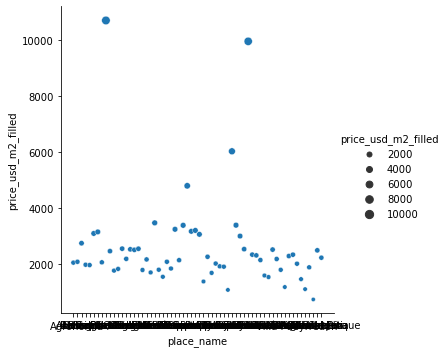

In [26]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.relplot(x = 'place_name', y = 'price_usd_m2_filled', data = df, size='price_usd_m2_filled', palette = 'ch:r=-0.5, l= 0.95')

plt.show()